In [3]:
import sqlite3
import numpy as np
import pandas as pd
import glob
import datetime
# modellen importeren
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Maak verbinding met de database
con = sqlite3.connect(r"D:\Code\Notebooks\SCADA_Bruggen") # zet hier het path naar je eigen database
cur = con.cursor()

'''
Laad de data van een brug uit de database
WHERE = data inladen vanaf 2016, als je dit niet begrijpt hoe het werkt is het geen probleem
De limit geeft aan dat je maar een bepaald aantal lines wil laden
'''

df = pd.read_sql("SELECT * FROM WGR", con)
con.close()

In [5]:
df.tail()

,index,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Tijd came,Tijd went,Tijd ack,Gebr.ID,DPE
6243026,6243026,01-12-2018 00:00:21.913,PROCES,NaN,34,NaN,UPS1.INFO.EXT_LUCHTVOCHTIGHEID,None,None,None,None,None,0.0,UPS1.INFO.EXT_LUCHTVOCHTIGHEID
6243027,6243027,01-12-2018 00:00:18.910,PROCES,NaN,33,NaN,UPS1.INFO.EXT_LUCHTVOCHTIGHEID,None,None,None,None,None,0.0,UPS1.INFO.EXT_LUCHTVOCHTIGHEID
6243028,6243028,01-12-2018 00:00:12.915,PROCES,NaN,34,NaN,UPS1.INFO.EXT_LUCHTVOCHTIGHEID,None,None,None,None,None,0.0,UPS1.INFO.EXT_LUCHTVOCHTIGHEID
6243029,6243029,01-12-2018 00:00:08.636,PROCES,NaN,1.7187497615814,NaN,Meteo Actuele Windkracht,None,None,None,None,None,0.0,DB_H61-Meteo-S.Meteodata.Windkracht.Actueel
6243030,6243030,01-12-2018 00:00:03.630,PROCES,NaN,225,NaN,Meteo Actuele Windrichting,None,None,None,None,None,0.0,DB_H61-Meteo-S.Meteodata.Windrichting.Actueel


## Windkracht dataframe

In [6]:
wkdf = df[df.Omschrijving == 'Meteo Actuele Windkracht']

wkdf = wkdf[['Tijd', 'Waarde']].copy()
wkdf['Tijd'] = pd.to_datetime(wkdf.Tijd, dayfirst = True)
wkdf['Waarde'] = wkdf.Waarde.astype('float')

# negatieve windkracht heb ik nog nooit gezien, dus die nemen we niet mee
wkdf = wkdf[wkdf.Waarde > 0]
wkdf.columns = ['time','Wk']

# check of alles gelukt is
wkdf.describe()

,Wk
count,6.146240e+05
mean,1.841414e+00
std,1.219557e+00
min,5.712112e-09
25%,9.573928e-01
50%,1.594329e+00
75%,2.449364e+00
max,1.488715e+01


In [7]:
wkdf.tail()

,time,Wk
6242886,2018-12-01 00:46:32.423,1.715133
6242944,2018-12-01 00:34:34.965,0.652488
6242977,2018-12-01 00:26:17.965,1.705367
6242982,2018-12-01 00:24:17.653,0.609809
6243029,2018-12-01 00:00:08.636,1.718750


## Windrichting

In [8]:
# Haal windrichting data uit standaard df 
wrdf = df[df.Omschrijving == 'Meteo Actuele Windrichting']

# zet de types om naar werkbare types
wrdf['Tijd'] = pd.to_datetime(wrdf.Tijd, dayfirst = True)
wrdf['Waarde'] = wrdf.Waarde.astype('float')

# negatieve windrichtingen bestaan niet
wrdf = wrdf[wrdf.Waarde > 0]

# Maak df met allen tijd en waarde kolom
wrdf = wrdf[['Tijd', 'Waarde']].copy()

# Pas kolom namen aan zodat het later gemerged kan worden en duidelijk blijft
wrdf.columns = ['time','WR']
wrdf.head()

#check of alles gelukt is
wrdf.info()

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 790178 entries, 8 to 6243030
Data columns (total 2 columns):
time    790178 non-null datetime64[ns]
WR      790178 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.1 MB


## Brug Beweging DataFrame

In [9]:
# Maak een df met daarin alle meldingen die te maken hebben met het openen en sluiten van de brug

OpenSluit = df[df.Omschrijving == 'Brug Beweging Actief']
SluitOpen = OpenSluit.append(df[df.Omschrijving == 'Algemeen Commando Brug Openen'])
OpenSluitBeweging = SluitOpen.append(df[df.Omschrijving == 'Algemeen Commando Brug Sluiten']) 
OpenSluitBeweging.Tijd = pd.to_datetime(OpenSluitBeweging.Tijd, dayfirst = True)

In [10]:
OpenSluitBeweging.head()

,index,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Tijd came,Tijd went,Tijd ack,Gebr.ID,DPE
809,809,2015-12-02 17:34:20.536,PROCES,NaN,FALSE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR
899,899,2015-12-02 17:33:03.831,PROCES,NaN,TRUE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR
972,972,2015-12-02 17:31:07.926,PROCES,NaN,FALSE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR
1049,1049,2015-12-02 17:30:02.635,PROCES,NaN,TRUE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR
1544,1544,2015-12-02 15:54:49.231,PROCES,NaN,FALSE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR


In [11]:
OpenSluitBeweging.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45195 entries, 809 to 6240596
Data columns (total 14 columns):
index           45195 non-null int64
Tijd            45195 non-null datetime64[ns]
Type            45195 non-null object
Klasse          0 non-null float64
Waarde          45195 non-null object
ID              0 non-null float64
Omschrijving    45195 non-null object
Status          0 non-null object
Prioriteit      0 non-null object
Tijd came       0 non-null object
Tijd went       0 non-null object
Tijd ack        0 non-null object
Gebr.ID         45195 non-null float64
DPE             45195 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(9)
memory usage: 5.2+ MB


In [12]:
# Sorteer het df op datum. (je sorteert op index omdat Tijd kolom niet mee wilden werken)
Duur = OpenSluitBeweging.sort_index()

In [13]:
Duur.head()

,index,Tijd,Type,Klasse,Waarde,ID,Omschrijving,Status,Prioriteit,Tijd came,Tijd went,Tijd ack,Gebr.ID,DPE
809,809,2015-12-02 17:34:20.536,PROCES,NaN,FALSE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR
881,881,2015-12-02 17:33:06.024,PROCES,NaN,FALSE,NaN,Algemeen Commando Brug Sluiten,None,None,None,None,None,0.0,DB_D00-Algemeen-S.CMD.BrugSl.Cmd
899,899,2015-12-02 17:33:03.831,PROCES,NaN,TRUE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR
900,900,2015-12-02 17:33:03.738,PROCES,NaN,TRUE,NaN,Algemeen Commando Brug Sluiten,None,None,None,None,None,40.0,DB_D00-Algemeen-S.CMD.BrugSl.Cmd
972,972,2015-12-02 17:31:07.926,PROCES,NaN,FALSE,NaN,Brug Beweging Actief,None,None,None,None,None,0.0,DB_A11-Brug-S.Status.BewR


In [14]:
# Maak een kolom in df met daarin de tijd omgezet naar seconden, zodat het makkelijker rekenen wordt
Duur['seconden'] = (Duur.Tijd.astype(np.int64) // 10**9)

In [15]:
Duur.to_csv('beweging.csv')

In [16]:
begin = 0
eind = 0
x = 0
tst = None
sluit = True
duur = list()
oslist = list()
timestamp = list()

for index, row in Duur.iterrows():
    waarde = row[4]
    oms = row[6]
    sec = row[14]
    ts = row[1]
    if ((oms == 'Brug Beweging Actief') & (waarde == "TRUE")):
        begin = sec
        tst = ts       
    elif ((oms == 'Brug Beweging Actief') & (waarde == "FALSE")):
        eind = sec
    if (oms == 'Algemeen Commando Brug Openen'):
        sluit = False
    elif (oms == 'Algemeen Commando Brug Sluiten'):
        sluit = True
    if ((eind!=0) & (begin!=0)):
        duur.append(eind-begin)
        timestamp.append(ts)
        oslist.append(sluit)
        eind = 0
        begin = 0
    

In [17]:
# maak het nieuwe df aan
duurdf  = pd.DataFrame(duur)
duurdf['beweging'] = oslist
duurdf['time'] = timestamp

In [18]:
# 0 == sluit
# oneven == open

duurdf.head()

,0,beweging,time
0,77,True,2015-12-02 17:33:03.831
1,65,False,2015-12-02 17:30:02.635
2,77,True,2015-12-02 15:53:32.220
3,65,False,2015-12-02 15:51:41.415
4,76,True,2015-12-02 12:35:27.726


In [19]:
duurdf.columns = ['duur','beweging','time']

In [20]:
duurdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11280 entries, 0 to 11279
Data columns (total 3 columns):
duur        11280 non-null int64
beweging    11280 non-null bool
time        11280 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(1)
memory usage: 187.3 KB


# Mergen van verschillende dataframes

## maak één dataframe met  daarin alle waarden die nodig  zijn

In [21]:
# samenvoegen van duur data en windrichting
# sorteer de dataframes op de time kolom, anders werkt de merge_asof niet
sortedduur = duurdf.sort_values('time')
sortedwr  =  wrdf.sort_values('time')

# voeg de gesorteerde dataframes samen gelet op de time kolom, waarbij hij zoekt naar de eerstvoorgaande time waarde
mergeddf = pd.merge_asof(sortedduur,sortedwr, on = 'time')

In [22]:
# hetzelfde als hierboven maar dan met de windkracht
sortedmerged = mergeddf.sort_values('time')
sortedwk  =  wkdf.sort_values('time')
duurWrWk = pd.merge_asof(sortedmerged,sortedwk, on = 'time')

In [23]:
duurWrWk.tail(10)

,duur,beweging,time,WR,Wk
11270,86,False,2018-11-29 19:38:07.140,160.0,3.234954
11271,95,True,2018-11-29 19:45:26.934,159.0,3.233146
11272,87,False,2018-11-30 10:39:20.252,212.0,2.927517
11273,96,True,2018-11-30 10:42:19.746,238.0,1.816768
11274,87,False,2018-11-30 11:10:47.855,233.0,1.843171
11275,94,True,2018-11-30 11:13:45.053,234.0,1.843171
11276,87,False,2018-11-30 16:01:36.632,186.0,1.308956
11277,95,True,2018-11-30 16:06:35.532,228.0,1.308956
11278,88,False,2018-12-01 11:13:00.934,147.0,2.500723
11279,97,True,2018-12-01 11:16:19.036,204.0,1.468461


## check voor outliers

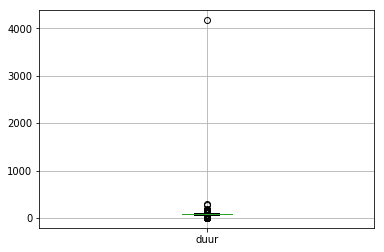

In [24]:
duurWrWk.boxplot('duur')

## Grafieken sluiten brug

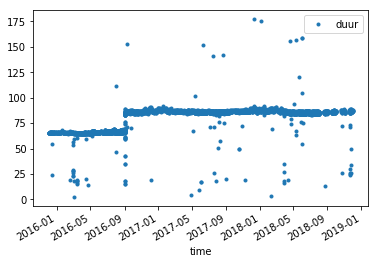

In [25]:
# Duur tegenover tijd
openen = duurWrWk[duurWrWk.beweging == False]
openen.plot(x = "time", y = 'duur', style = '.')

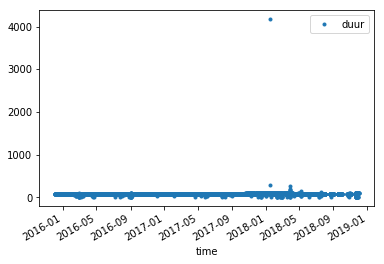

In [26]:
# duur tegenover tijd
sluit = duurWrWk[duurWrWk.beweging == True]
sluit.plot(x = "time", y = 'duur', style = '.')

In [71]:
sluit.duur.describe()

count    5665.000000
mean       81.858429
std        55.509057
min         1.000000
25%        77.000000
50%        80.000000
75%        88.000000
max      4167.000000
Name: duur, dtype: float64

In [28]:
sluitin = sluit[sluit.duur > 75]
sluitout = sluit[sluit.duur < 75]

In [29]:
sluitin.shape

(5103, 5)

In [30]:
sluitout.shape

(368, 5)

In [31]:
sluitPerOut = ((131/5821)*100)
sluitPerOut

2.2504724274179693

In [32]:
openin = openen[(openen.duur >= 75) & (openen.duur <= 125)]
openout = openen[(openen.duur < 75) | (openen.duur > 125)]

In [33]:
openin.shape

(4077, 5)

In [34]:
openout.shape

(1538, 5)

In [35]:
openPerOut = ((258/5861)*100)
openPerOut

4.401979184439515

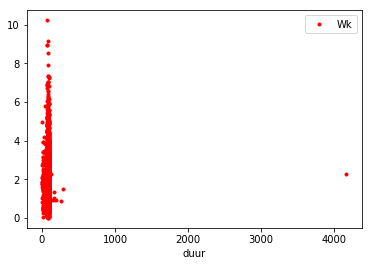

In [36]:
# duur tegenover windkracht
sluit.plot(x = "duur", y = 'Wk', style = '.', color = 'red')

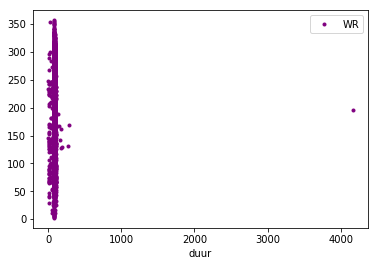

In [37]:
# Duur tegenover windrichting
sluit.plot(x = "duur", y = 'WR', style = '.', color = 'purple')

## Grafieken openen

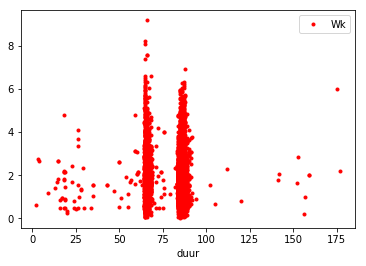

In [38]:
# Duur tegenover windkracht
openen.plot(x = "duur", y = 'Wk', style = '.', color = 'red')

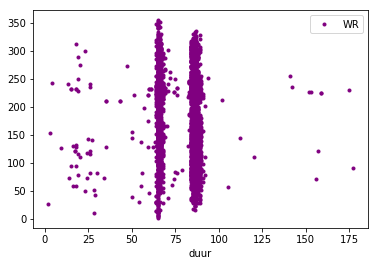

In [39]:
# Duur tegenover Windrichting
openen.plot(x = "duur", y = 'WR', style = '.', color = 'purple')

## Data Cleaning

In [72]:
# haal de outliers uit de data
cleanDuur = duurWrWk[duurWrWk.duur >  50]
cleanDuur = cleanDuur[cleanDuur.duur < 125]
cleanDuur.describe()

,duur,WR,Wk
count,11107.000000,11107.000000,11107.000000
mean,81.372828,192.499055,1.916665
std,8.061214,70.149527,1.119114
min,51.000000,2.000000,0.005425
25%,77.000000,139.000000,1.086516
50%,85.000000,215.000000,1.718027
75%,87.000000,238.000000,2.517541
max,120.000000,357.000000,10.221354


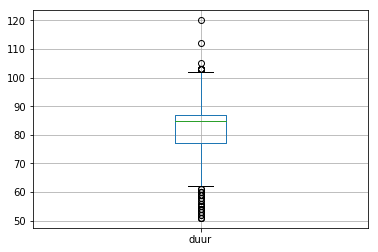

In [73]:
cleanDuur.boxplot('duur')

## Duur van openen bruggen over de tijd

In [74]:
cleanOpen = cleanDuur[cleanDuur.beweging == False]

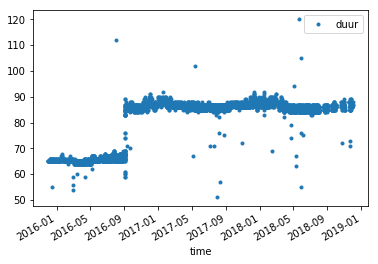

In [75]:
cleanOpen.plot(x = 'time', y ='duur', style = '.')

## Duur van sluiten bruggen over de tijd

In [76]:
cleanSluit = cleanDuur[cleanDuur.beweging == True]

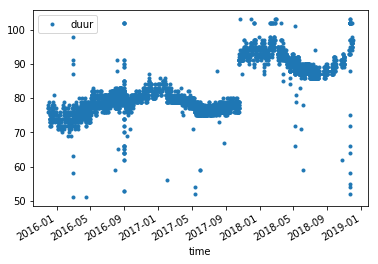

In [77]:
cleanSluit.plot(x = "time", y = 'duur', style = '.')

## data prep voor dagdeel

In [78]:
# Uur kolom maken om dagdeel te bepalen.
cleanOpen['uur'] = cleanOpen.time.dt.hour
cleanSluit['uur'] = cleanSluit.time.dt.hour
cleanDuur['uur'] = cleanDuur.time.dt.hour

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Boxplots
## Boxplots per dagdeel

([<matplotlib.axis.XTick at 0x1c13a6fa390>,
 <a list of 4 Text xticklabel objects>)

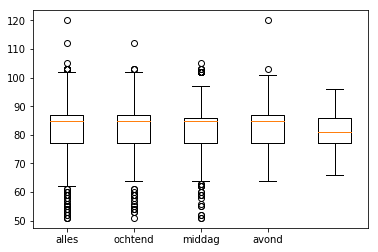

In [79]:
ochtendDuur = cleanDuur[((cleanDuur.uur >= 6)  & (cleanDuur.uur <= 12))]
middagDuur = cleanDuur[((cleanDuur.uur >= 13)  & (cleanDuur.uur <= 18))]
avondDuur = cleanDuur[((cleanDuur.uur >= 19)  & (cleanDuur.uur <= 24))]
nachtDuur = cleanDuur[((cleanDuur.uur >= 0)  & (cleanDuur.uur <= 5))]
data  = [cleanDuur.duur, ochtendDuur.duur, middagDuur.duur, avondDuur.duur, nachtDuur.duur]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4], ('alles','ochtend', 'middag','avond', 'nacht'))

## Boxplot openen dagdeel

Text(0, 0.5, 'Duur (s)')

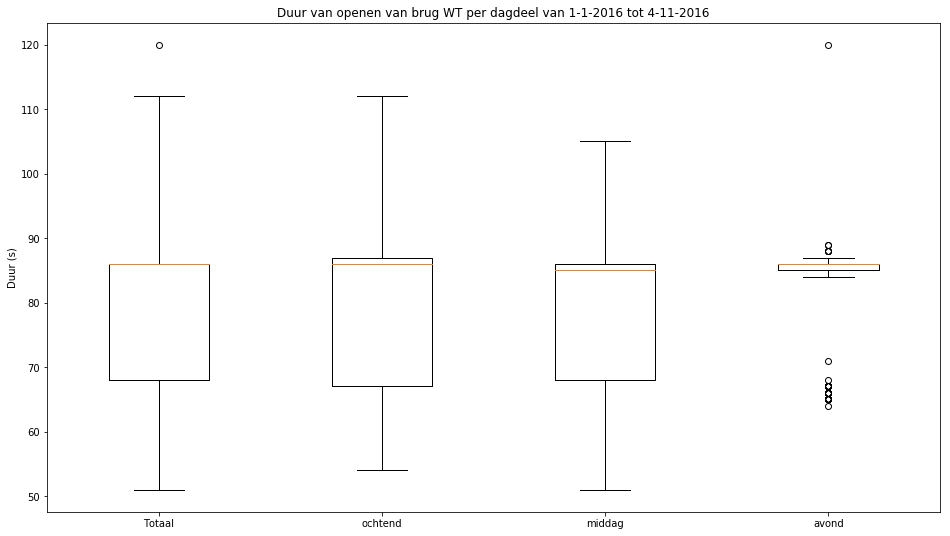

In [80]:
# maak nieuwe dataframes met daarin alle ochtend, middag en avond openingen.
# Deze brug opent in deze periode niet s'nachts

ochtendDuurOpen = cleanOpen[((cleanOpen.uur >= 6)  & (cleanOpen.uur <= 12))]
middagDuurOpen= cleanOpen[((cleanOpen.uur >= 13)  & (cleanOpen.uur <= 18))]
avondDuurOpen = cleanOpen[((cleanOpen.uur >= 19)  & (cleanOpen.uur <= 24))]

# selecteer de data om in de boxplot te zetten
dataOpen  = [cleanOpen.duur, ochtendDuurOpen.duur, middagDuurOpen.duur, avondDuurOpen.duur]

# Boxplot
plt.figure(figsize=(16,9))
plt.boxplot(dataOpen)
plt.xticks([1, 2, 3, 4], ('Totaal','ochtend', 'middag','avond'))
plt.title('Duur van openen van brug WT per dagdeel van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

## Boxplot sluiten per dagdeel

Text(0, 0.5, 'Duur (s)')

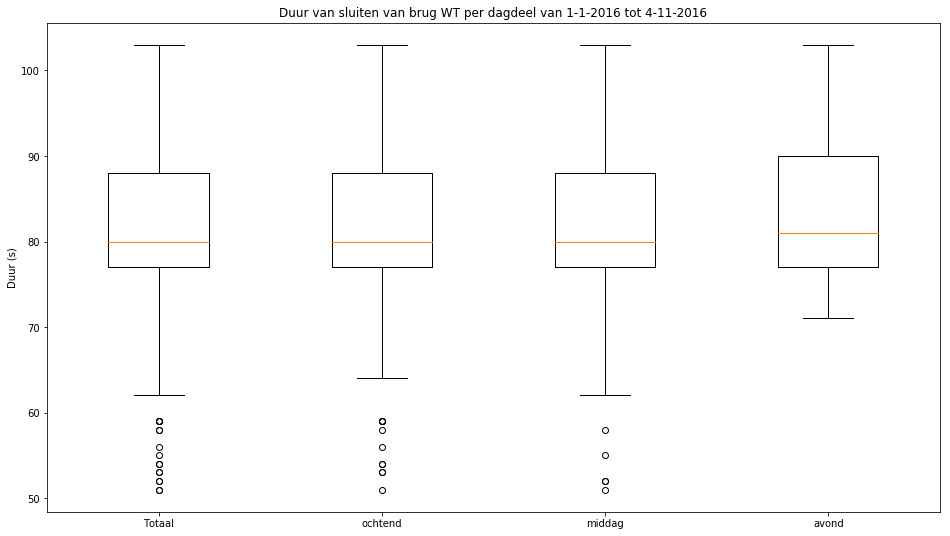

In [81]:
ochtendDuurSluit = cleanSluit[((cleanSluit.uur >= 6)  & (cleanSluit.uur <= 12))]
middagDuurSluit= cleanSluit[((cleanSluit.uur >= 13)  & (cleanSluit.uur <= 18))]
avondDuurSluit = cleanSluit[((cleanSluit.uur >= 19)  & (cleanSluit.uur <= 24))]
dataSluit  = [cleanSluit.duur, ochtendDuurSluit.duur, middagDuurSluit.duur, avondDuurSluit.duur]
plt.figure(figsize=(16,9))
plt.boxplot(dataSluit)
plt.xticks([1, 2, 3, 4], ('Totaal','ochtend', 'middag','avond'))
plt.title('Duur van sluiten van brug WT per dagdeel van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

## Boxplots per windrichting

([<matplotlib.axis.XTick at 0x1c0d2051860>,
 <a list of 9 Text xticklabel objects>)

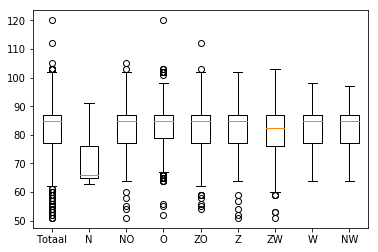

In [82]:
cleanDuur['N'] = ((cleanDuur.WR >= 0) & (cleanDuur.WR <= 22.5) | (cleanDuur.WR >= 337.6) & (cleanDuur.WR <= 360)).astype('int')
cleanDuur['NO'] = ((cleanDuur.WR >=22.6) & (cleanDuur.WR <= 67.5)).astype('int')
cleanDuur['O'] = ((cleanDuur.WR >=67.6) & (cleanDuur.WR <= 112.5)).astype('int')
cleanDuur['ZO'] = ((cleanDuur.WR >=112.6) & (cleanDuur.WR <= 157.5)).astype('int')
cleanDuur['Z'] = ((cleanDuur.WR >=157.6) & (cleanDuur.WR <= 202.5)).astype('int')
cleanDuur['ZW'] = ((cleanDuur.WR >=202.6) & (cleanDuur.WR <= 247.2)).astype('int')
cleanDuur['W'] = ((cleanDuur.WR>=247.6) & (cleanDuur.WR <= 292.5)).astype('int')
cleanDuur['NW'] = ((cleanDuur.WR >=292.6) & (cleanDuur.WR <= 337.5)).astype('int')

N = cleanDuur[cleanDuur.N == 1]
NO = cleanDuur[cleanDuur.NO == 1]
O = cleanDuur[cleanDuur.O == 1]
ZO = cleanDuur[cleanDuur.ZO == 1]
Z = cleanDuur[cleanDuur.Z == 1]
ZW = cleanDuur[cleanDuur.ZW == 1]
W = cleanDuur[cleanDuur.W == 1]
NW = cleanDuur[cleanDuur.NW == 1]

data = [cleanDuur.duur, N.duur,NO.duur,O.duur,ZO.duur,Z.duur, ZW.duur, W.duur, NW.duur]
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ('Totaal','N','NO','O','ZO' ,'Z' ,'ZW','W','NW'))

## Boxplot duur openen per windrichting

Text(0, 0.5, 'Duur (s)')

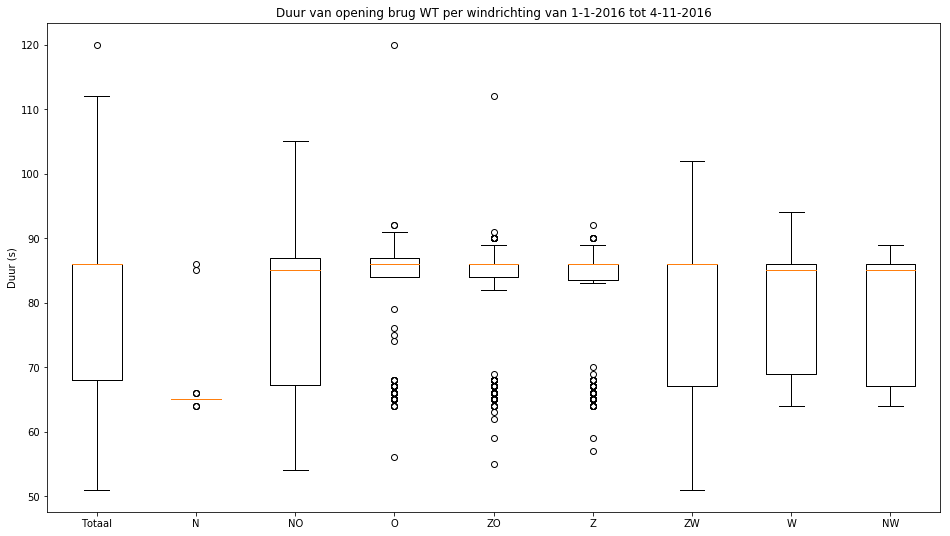

In [83]:
# dataframes aanmaken met alleen de data per windrichting, dus dataframe voor Noord, Oost, etc.
openN = cleanOpen[((cleanOpen.WR >= 0) & (cleanOpen.WR <= 22.5) | (cleanOpen.WR >= 337.6) & (cleanOpen.WR <= 360))]
openNO = cleanOpen[((cleanOpen.WR >=22.6) & (cleanOpen.WR <= 67.5))]
openO = cleanOpen[((cleanOpen.WR >=67.6) & (cleanOpen.WR <= 112.5))]
openZO = cleanOpen[((cleanOpen.WR >=112.6) & (cleanOpen.WR <= 157.5))]
openZ = cleanOpen[((cleanOpen.WR >=157.6) & (cleanOpen.WR <= 202.5))]
openZW = cleanOpen[((cleanOpen.WR >=202.6) & (cleanOpen.WR <= 247.2))]
openW = cleanOpen[((cleanOpen.WR>=247.6) & (cleanOpen.WR <= 292.5))]
openNW = cleanOpen[((cleanOpen.WR >=292.6) & (cleanOpen.WR <= 337.5))]

# selecteer data voor plot
data = [cleanOpen.duur, openN.duur,openNO.duur,openO.duur,openZO.duur,openZ.duur, openZW.duur, openW.duur, openNW.duur]

# Boxplot
plt.figure(figsize=(16,9))
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ('Totaal','N','NO','O','ZO' ,'Z' ,'ZW','W','NW'))
plt.title('Duur van opening brug WT per windrichting van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

## Boxplot duur sluiten per windrichting

Text(0, 0.5, 'Duur (s)')

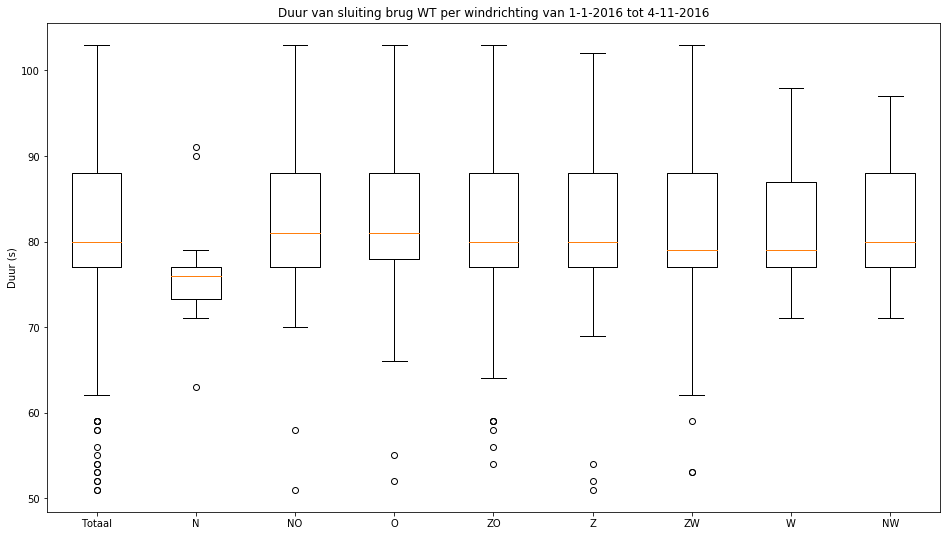

In [84]:
sluitN = cleanSluit[((cleanSluit.WR >= 0) & (cleanSluit.WR <= 22.5) | (cleanSluit.WR >= 337.6) & (cleanSluit.WR <= 360))]
sluitNO = cleanSluit[((cleanSluit.WR >=22.6) & (cleanSluit.WR <= 67.5))]
sluitO = cleanSluit[((cleanSluit.WR >=67.6) & (cleanSluit.WR <= 112.5))]
sluitZO = cleanSluit[((cleanSluit.WR >=112.6) & (cleanSluit.WR <= 157.5))]
sluitZ = cleanSluit[((cleanSluit.WR >=157.6) & (cleanSluit.WR <= 202.5))]
sluitZW = cleanSluit[((cleanSluit.WR >=202.6) & (cleanSluit.WR <= 247.2))]
sluitW = cleanSluit[((cleanSluit.WR>=247.6) & (cleanSluit.WR <= 292.5))]
sluitNW = cleanSluit[((cleanSluit.WR >=292.6) & (cleanSluit.WR <= 337.5))]

data = [cleanSluit.duur, sluitN.duur,sluitNO.duur,sluitO.duur,sluitZO.duur,sluitZ.duur, sluitZW.duur, sluitW.duur, sluitNW.duur]

plt.figure(figsize=(16,9))
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ('Totaal','N','NO','O','ZO' ,'Z' ,'ZW','W','NW'))
plt.title('Duur van sluiting brug WT per windrichting van 1-1-2016 tot 4-11-2016')
plt.ylabel('Duur (s)')

# Scatter duur openen

In [85]:
wrbin = list()
for index, row in cleanOpen.iterrows():
    wr = row[3]
    wk = row[4]
    if(((wr >= 0) & (wr<=22.5))| ((wr >= 337.6) & (wr<=360))):
        wrbin.append(0)      
    elif((wr >= 22.6) & (wr<=67.5)):
        wrbin.append(1)
    elif((wr >= 67.6) & (wr<=112.5)):
        wrbin.append(2)
    elif((wr >= 112.6) & (wr<=157.5)):
        wrbin.append(3)
    elif((wr >= 157.6) & (wr<=202.5)):
        wrbin.append(4)
    elif((wr >= 202.6) & (wr<=247.5)):
        wrbin.append(5)
    elif((wr >= 247.6) & (wr<=292.5)):
        wrbin.append(6)
    elif((wr >= 292.6) & (wr<=337.5)):
        wrbin.append(7)
cleanOpen['WRbin'] = wrbin
cleanOpen.head()

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duur,beweging,time,WR,Wk,uur,WRbin
0,65,False,2015-12-02 11:18:03.719,227.0,0.303819,11,5
2,65,False,2015-12-02 12:32:28.529,241.0,1.714410,12,5
4,65,False,2015-12-02 15:51:41.415,217.0,1.085069,15,5
6,65,False,2015-12-02 17:30:02.635,243.0,3.385417,17,5
8,65,False,2015-12-03 08:02:02.330,163.0,0.477431,8,4


In [86]:
cleanOpen.Wk.describe()

count    5553.000000
mean        1.923728
std         1.117254
min         0.021340
25%         1.095197
50%         1.726707
75%         2.507234
max         9.179688
Name: Wk, dtype: float64

In [87]:
wkbin = list()
for index, row in cleanOpen.iterrows():
    wk = row[4]
    if((wk >= 0) & (wk<=0.2)):
        wkbin.append(0)      
    elif((wk > 0.2) & (wk<=1.5)):
        wkbin.append(1)
    elif((wk > 1.5) & (wk<=3.3)):
        wkbin.append(2)
    elif((wk > 3.3) & (wk<=5.4)):
        wkbin.append(3)
    elif((wk > 5.4) & (wk<=7.9)):
        wkbin.append(4)
    elif((wk > 7.9) & (wk<=10.7)):
        wkbin.append(5)
    elif((wk > 10.7) & (wk<=13.8)):
        wkbin.append(6)
    elif((wk > 13.8) & (wk<=17.1)):
        wkbin.append(7)
    elif((wk > 17.1) & (wk<=20.7)):
        wkbin.append(8)   
    elif((wk > 20.7) & (wk<=24.4)):
        wkbin.append(9)
    elif((wk > 24.4) & (wk<=28.4)):
        wkbin.append(10)
cleanOpen['WKbin'] = wkbin
cleanOpen.head()


C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duur,beweging,time,WR,Wk,uur,WRbin,WKbin
0,65,False,2015-12-02 11:18:03.719,227.0,0.303819,11,5,1
2,65,False,2015-12-02 12:32:28.529,241.0,1.714410,12,5,2
4,65,False,2015-12-02 15:51:41.415,217.0,1.085069,15,5,1
6,65,False,2015-12-02 17:30:02.635,243.0,3.385417,17,5,3
8,65,False,2015-12-03 08:02:02.330,163.0,0.477431,8,4,1


Text(0.5, 1.0, 'Duur per windrichting')

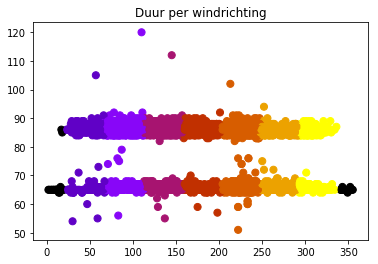

In [88]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.WR, cleanOpen.duur, c = cleanOpen.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

Text(0.5, 1.0, 'Duur per windrichting')

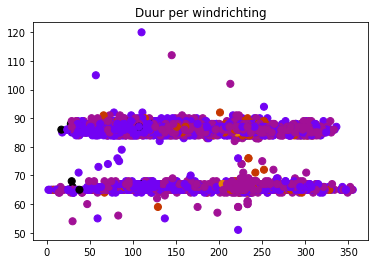

In [89]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.WR, cleanOpen.duur, c = cleanOpen.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

Text(0.5, 1.0, 'Duur per windkracht')

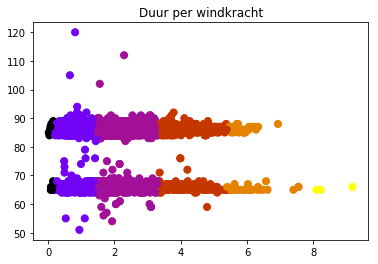

In [90]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.Wk, cleanOpen.duur, c = cleanOpen.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

Text(0.5, 1.0, 'Duur per windkracht')

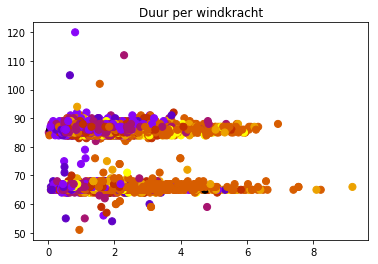

In [91]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanOpen.Wk, cleanOpen.duur, c = cleanOpen.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

# Scatter duur sluiten

In [92]:
wrbin = list()
for index, row in cleanSluit.iterrows():
    wr = row[3]
    wk = row[4]
    if(((wr >= 0) & (wr<=22.5))| ((wr >= 337.6) & (wr<=360))):
        wrbin.append(0)      
    elif((wr >= 22.6) & (wr<=67.5)):
        wrbin.append(1)
    elif((wr >= 67.6) & (wr<=112.5)):
        wrbin.append(2)
    elif((wr >= 112.6) & (wr<=157.5)):
        wrbin.append(3)
    elif((wr >= 157.6) & (wr<=202.5)):
        wrbin.append(4)
    elif((wr >= 202.6) & (wr<=247.5)):
        wrbin.append(5)
    elif((wr >= 247.6) & (wr<=292.5)):
        wrbin.append(6)
    elif((wr >= 292.6) & (wr<=337.5)):
        wrbin.append(7)
cleanSluit['WRbin'] = wrbin
cleanSluit.head()

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duur,beweging,time,WR,Wk,uur,WRbin
1,78,True,2015-12-02 11:21:24.019,209.0,1.801215,11,5
3,76,True,2015-12-02 12:35:27.726,212.0,0.824653,12,5
5,77,True,2015-12-02 15:53:32.220,165.0,0.976562,15,4
7,77,True,2015-12-02 17:33:03.831,248.0,2.929688,17,6
9,76,True,2015-12-03 08:10:26.318,32.0,1.106771,8,1


In [93]:
wkbin = list()
for index, row in cleanSluit.iterrows():
    wk = row[4]
    if((wk >= 0) & (wk<=0.2)):
        wkbin.append(0)      
    elif((wk > 0.2) & (wk<=1.5)):
        wkbin.append(1)
    elif((wk > 1.5) & (wk<=3.3)):
        wkbin.append(2)
    elif((wk > 3.3) & (wk<=5.4)):
        wkbin.append(3)
    elif((wk > 5.4) & (wk<=7.9)):
        wkbin.append(4)
    elif((wk > 7.9) & (wk<=10.7)):
        wkbin.append(5)
    elif((wk > 10.7) & (wk<=13.8)):
        wkbin.append(6)
    elif((wk > 13.8) & (wk<=17.1)):
        wkbin.append(7)
    elif((wk > 17.1) & (wk<=20.7)):
        wkbin.append(8)   
    elif((wk > 20.7) & (wk<=24.4)):
        wkbin.append(9)
    elif((wk > 24.4) & (wk<=28.4)):
        wkbin.append(10)
cleanSluit['WKbin'] = wkbin
cleanSluit.head()

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duur,beweging,time,WR,Wk,uur,WRbin,WKbin
1,78,True,2015-12-02 11:21:24.019,209.0,1.801215,11,5,2
3,76,True,2015-12-02 12:35:27.726,212.0,0.824653,12,5,1
5,77,True,2015-12-02 15:53:32.220,165.0,0.976562,15,4,1
7,77,True,2015-12-02 17:33:03.831,248.0,2.929688,17,6,2
9,76,True,2015-12-03 08:10:26.318,32.0,1.106771,8,1,1


Text(0.5, 1.0, 'Duur per windrichting')

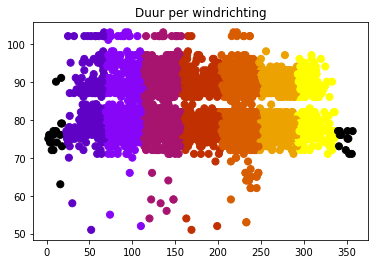

In [94]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.WR, cleanSluit.duur, c = cleanSluit.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

Text(0.5, 1.0, 'Duur per windrichting')

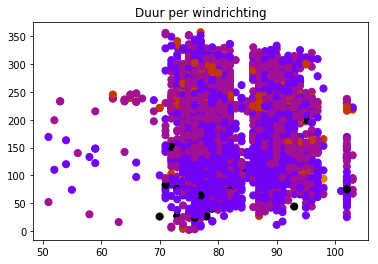

In [95]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.duur, cleanSluit.WR,  c = cleanSluit.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

Text(0.5, 1.0, 'Duur per windrichting')

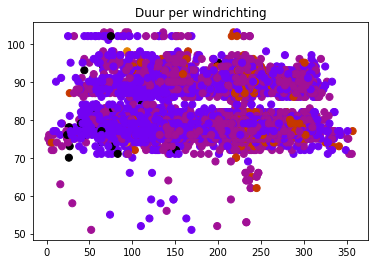

In [96]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.WR, cleanSluit.duur, c = cleanSluit.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windrichting")

Text(0.5, 1.0, 'Duur per windkracht')

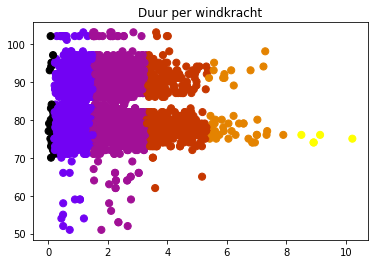

In [97]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.Wk, cleanSluit.duur, c = cleanSluit.WKbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

Text(0.5, 1.0, 'Duur per windkracht')

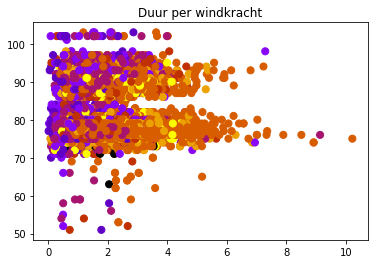

In [98]:
fig, ax = plt.subplots()
scatter = ax.scatter(cleanSluit.Wk, cleanSluit.duur, c = cleanSluit.WRbin,  s=50, cmap='gnuplot')
ax.set_title("Duur per windkracht")

In [99]:
wrbin = list()
for index, row in openen.iterrows():
    wr = row[3]
    wk = row[4]
    if(((wr >= 0) & (wr<=22.5))| ((wr >= 337.6) & (wr<=360))):
        wrbin.append(0)      
    elif((wr >= 22.6) & (wr<=67.5)):
        wrbin.append(1)
    elif((wr >= 67.6) & (wr<=112.5)):
        wrbin.append(2)
    elif((wr >= 112.6) & (wr<=157.5)):
        wrbin.append(3)
    elif((wr >= 157.6) & (wr<=202.5)):
        wrbin.append(4)
    elif((wr >= 202.6) & (wr<=247.5)):
        wrbin.append(5)
    elif((wr >= 247.6) & (wr<=292.5)):
        wrbin.append(6)
    elif((wr >= 292.6) & (wr<=337.5)):
        wrbin.append(7)
openen['WRbin'] = wrbin
openen.head()

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duur,beweging,time,WR,Wk,WRbin,WKbin
0,65,False,2015-12-02 11:18:03.719,227.0,0.303819,5,1
2,65,False,2015-12-02 12:32:28.529,241.0,1.714410,5,2
4,65,False,2015-12-02 15:51:41.415,217.0,1.085069,5,1
6,65,False,2015-12-02 17:30:02.635,243.0,3.385417,5,3
8,65,False,2015-12-03 08:02:02.330,163.0,0.477431,4,1


In [100]:
wkbin = list()
for index, row in openen.iterrows():
    wk = row[4]
    if((wk >= 0) & (wk<=0.2)):
        wkbin.append(0)      
    elif((wk > 0.2) & (wk<=1.5)):
        wkbin.append(1)
    elif((wk > 1.5) & (wk<=3.3)):
        wkbin.append(2)
    elif((wk > 3.3) & (wk<=5.4)):
        wkbin.append(3)
    elif((wk > 5.4) & (wk<=7.9)):
        wkbin.append(4)
    elif((wk > 7.9) & (wk<=10.7)):
        wkbin.append(5)
    elif((wk > 10.7) & (wk<=13.8)):
        wkbin.append(6)
    elif((wk > 13.8) & (wk<=17.1)):
        wkbin.append(7)
    elif((wk > 17.1) & (wk<=20.7)):
        wkbin.append(8)   
    elif((wk > 20.7) & (wk<=24.4)):
        wkbin.append(9)
    elif((wk > 24.4) & (wk<=28.4)):
        wkbin.append(10)
openen['WKbin'] = wkbin
openen.head()

C:\Users\denni\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duur,beweging,time,WR,Wk,WRbin,WKbin
0,65,False,2015-12-02 11:18:03.719,227.0,0.303819,5,1
2,65,False,2015-12-02 12:32:28.529,241.0,1.714410,5,2
4,65,False,2015-12-02 15:51:41.415,217.0,1.085069,5,1
6,65,False,2015-12-02 17:30:02.635,243.0,3.385417,5,3
8,65,False,2015-12-03 08:02:02.330,163.0,0.477431,4,1


# Dataframe omzetten naar CSV


In [101]:
cleanOpen.to_csv('DuurOpening.csv')
cleanSluit.to_csv('DuurSluiten.csv')
cleanDuur.to_csv('CleanedDuur.csv')
openen.to_csv('Open.csv')
sluit.to_csv('Sluiten.csv')